In [1]:
# libraries
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import urllib
from random import choices
from itertools import chain
# Levenshtein Distance in Python
import textdistance
import re
import unicodedata
from rank_bm25 import BM25Okapi, BM25L
# https://github.com/seatgeek/thefuzz
from thefuzz import fuzz, process

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

# Pandas config
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# set random seed
np.random.seed(seed=42)

### Offers training

In [3]:
offers_training_df = pd.read_parquet('offers_training.parquet')
offers_test_df = pd.read_parquet('offers_test.parquet')

## Brand analysis

### Brand text processing
- Lower case text
- Accented vowels removal `è, é, ... -> e`
- Stop words removal (German)

In [4]:
stop_word_list = []

with open('german_stopwords.txt', "r") as f:
    stop_word_list = f.read().split()

In [5]:
class TextTransformer:
    def __init__(self, text):
        self.text = text
    def processed_text(self):
        if self.text is None:
            return ''
        #lower
        processed = self.text.lower()
        #remove accents
        processed = self.simplify(processed)
        #remove special characters
        processed = ''.join(c if c.isalnum() or c == ' ' else ' ' for c in processed)
        #remove unnecessary double spaces
        processed = re.sub(' +', ' ', processed)
        #strip
        processed = processed.strip()
        #remove stopwords
        processed_list = [word for word in processed.split() if word not in stop_word_list]
        return ' '.join(processed_list)
    
    def simplify(self, text):
        try:
            text = unicode(text, 'utf-8')
        except NameError:
            pass
        text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
        return str(text)

### Class for brand management

In [6]:
brands_training = offers_training_df['brand'].unique()
brands_test = offers_test_df['brand'].unique()

In [7]:
def similarity(str_1, str_2):
    return textdistance.levenshtein.normalized_similarity(str_1, str_2)

In [8]:
class Brand:
    def __init__(self, name, parent=None, child=list()):
        self.name = name
        self.parent = parent
        self.child = child
    

In [9]:
class BrandCollection:
    def __init__(self, brand_list):
        self.brands = {}
        self.brand_family = {}
        #brand_list = [TextTransformer(x).processed_text() for x in brand_list]
        brand_list.sort()
        for el in brand_list:
            self.process_brand(Brand(el))
    
    def process_brand(self, brand):
        if brand.name not in self.brands:
            parent_likelyhood = 0
            likely_parent = None
            for k in self.brands.keys():
                comp = self.brands[k]
                l_comp = self.listify(comp, brand)
                l_brand = self.listify(brand, comp)
                calc_likelyhood = self.parent_likelyhood(l_comp, l_brand)
                if calc_likelyhood > parent_likelyhood:
                    parent_likelyhood = calc_likelyhood
                    brand.parent = comp
                    likely_parent = self.brands[comp.name]
            self.brands[brand.name] = brand
            self.brand_family[brand] = []
            if likely_parent is not None:
                self.brand_family[likely_parent].append(brand)
    
    def listify(self, brand, to_compare):
        l_brand = brand.name.split()
        l_comp = to_compare.name.split()
        max_len = len(l_brand) if len(l_brand) > len(l_comp) else len(l_comp)
        if len(l_brand) == max_len:
            return l_brand
        for i in range(max_len - len(l_brand)):
            l_brand += ['']
        return l_brand
    
    def parent_likelyhood(self, l_comp, l_brand):
        likelyhood = 0
        #check longest matching n-gram, does not check for combinations
        for i in range(len(l_comp)):
            if l_comp[i] == l_brand[i]:
                likelyhood += 1
            else:
                return likelyhood
        return likelyhood
    
    def similarity(self, str_1, str_2):
        return textdistance.levenshtein.normalized_similarity(str_1, str_2)
    
    def get_match(self, brand_query):
        brand_to_search = Brand(TextTransformer(brand_query).processed_text())
        if brand_to_search.name in self.brands:
            selected_brand = self.brands[brand_to_search.name]
            while selected_brand.parent is not None:
                selected_brand = selected_brand.parent
            brands = self.get_brand_family(selected_brand.name)
            return brands, 1
        else:
            relevance = 0
            most_relevant = '-'
            for key in self.brands.keys():
                sim = self.similarity(brand_to_search.name, self.brands[key].name)
                if sim > relevance:
                    relevance = sim
                    most_relevant = self.brands[key].name
            brands = self.get_brand_family(most_relevant)
            return brands, relevance
            
    def get_brand_family(self, brand_name):
        fam_list = [brand_name]
        family = []
        while len(fam_list) != 0:
            current = fam_list[0]
            fam_list += [b.name for b in self.brand_family[self.brands[current]]]
            fam_list.remove(current)
            if current not in family:
                family += [current]
        return family             

### Product name matching VSM - BM25

In [10]:
class TextRelevance:
    def __init__(self, text, relevance):
        self.text = text
        self.relevance = relevance
    def __repr__(self):
        return self.text + ' ' + str(self.relevance)
    def __eq__(self, other):
        return self.text == other.text
    def __hash__(self):
        return hash(self.text)

In [11]:
class BM25Z(BM25L):
    def __init__(self, corpus):
        super().__init__(self.process_list(corpus))
        self.corpus = self.process_list(corpus)
    def process_list(self, titles_list):
        return [text.split() for text in titles_list if text is not None]
    def processed_text(self, text):
        return TextTransformer(text).processed_text()
    def get_corpus_str(self):
        return [' '.join(el) for el in self.corpus]
    def get_corpus_scores(self, query):
        query = self.processed_text(query).split()
        return [TextRelevance(x,y) for x, y in zip(self.get_corpus_str(), self.get_scores(query))]
    def get_relevant_results(self, query, threshold=0):
        res = [el for el in self.get_corpus_scores(query) if el.relevance > threshold]
        res = sorted(res, key=lambda x: x.relevance, reverse=True)
        return res

In [12]:
matches_training_df = pd.read_parquet('matches_training.parquet')

zalando_prod_training = offers_training_df.loc[offers_training_df['shop'] == 'zalando']
zalando_prod_training = zalando_prod_training\
                    .loc[zalando_prod_training['offer_id'].isin(matches_training_df['zalando'])]
zalando_prod_training['brand'] = zalando_prod_training['brand']\
                    .apply(lambda x: TextTransformer(x).processed_text())
zalando_prod_training['title'] = zalando_prod_training['title']\
                    .apply(lambda x: TextTransformer(x).processed_text())
zalando_prod_training['color'] = zalando_prod_training['color']\
                    .apply(lambda x: TextTransformer(x).processed_text())
#zalando_prod_training['description'] = zalando_prod_training['description']\
#                    .apply(lambda x: TextTransformer(x).processed_text())

aboutyou_prod_training = offers_training_df.loc[offers_training_df['shop'] == 'aboutyou']
aboutyou_prod_training['brand'] = aboutyou_prod_training['brand']\
                    .apply(lambda x: TextTransformer(x).processed_text())
aboutyou_prod_training['title'] = aboutyou_prod_training['title']\
                    .apply(lambda x: TextTransformer(x).processed_text())
aboutyou_prod_training['color'] = aboutyou_prod_training['color']\
                    .apply(lambda x: TextTransformer(x).processed_text())
#aboutyou_prod_training['description'] = aboutyou_prod_training['description']\
#                    .apply(lambda x: TextTransformer(x).processed_text())

fields = ['shop','offer_id', 'brand', 'title', 'description']

brand_collection = BrandCollection(list(zalando_prod_training['brand']) + list(aboutyou_prod_training['brand']))

bm25matcher_title = BM25Z(list(aboutyou_prod_training['title']))

bm25matcher_color = BM25Z(list(aboutyou_prod_training['color']))

#bm25matcher_descr = BM25Z(list(aboutyou_prod_training['description']))

### Brand likelyhood
Brand matching categorize correctly up to 96% of offers, but the accuracy (number of results per query) is low: 0.1675

In [13]:
def brand_likely_matches(n):
    """
    n is the row number of the product in aboutyou dataset
    try to compare 1 zalando product with aboutyou products
    """
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    #get subset of possible brands to investigate
    match_brands, rel = brand_collection.get_match(prod_to_match['brand'])
    aboutyou_prod_brand_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['brand']\
                                .isin(match_brands)]
        
    if len(aboutyou_prod_brand_match['title']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_brand_match['offer_id'])}

### Title likelyhood
Title matching with BM25 categorize correctly up to 58% of offers, with good accuracy (number of results per query): 0.6214

In [14]:
def title_likely_matches(n):
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    
    match_titles_relevance = list(dict.fromkeys(bm25matcher_title.get_relevant_results(prod_to_match['title'])))
    match_titles = [x.text for x in match_titles_relevance]

    aboutyou_prod_title_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['title']\
                                .isin(match_titles)]
    
    if len(aboutyou_prod_title_match['title']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_title_match['offer_id'])}

In [15]:
def color_likely_matches(n):
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    
    match_titles_relevance = list(dict.fromkeys(bm25matcher_color.get_relevant_results(prod_to_match['color'])))
    match_titles = [x.text for x in match_titles_relevance]

    aboutyou_prod_color_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['color']\
                                .isin(match_titles)]
    
    if len(aboutyou_prod_color_match['color']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_color_match['offer_id'])}

In [16]:
#bm25matcher_color.idf
#aboutyou_prod_training[['color']].head(30)

In [17]:
def descr_likely_matches(n):
    try:
        prod_to_match = zalando_prod_training.loc[n]
        id_prod = prod_to_match['offer_id']
    except:
        return {'zalando_id' : None, 'aboutyou_ids' : []}
    
    match_titles_relevance = list(dict.fromkeys(bm25matcher_descr.get_relevant_results(prod_to_match['description'])))
    match_titles = [x.text for x in match_titles_relevance]

    aboutyou_prod_descr_match = aboutyou_prod_training\
                                .loc[aboutyou_prod_training['description']\
                                .isin(match_titles)]
    
    if len(aboutyou_prod_descr_match['color']) == 0:
        return {'zalando_id' : id_prod, 'aboutyou_ids' : []}
    
    return {'zalando_id' : id_prod, 'aboutyou_ids' : list(aboutyou_prod_descr_match['offer_id'])}

### Price analysis
Using groundtruth to understand price differences

In [55]:
from scipy import stats

In [88]:
def get_price_difference(limit = 500):
    price_diff = []
    for i in range(len(matches_training_df)):
        z_id = matches_training_df.loc[i]['zalando']
        a_id = matches_training_df.loc[i]['aboutyou']
        z_price = offers_training_df.loc[offers_training_df['offer_id'] == z_id]['price'].values[0]
        a_price = offers_training_df.loc[offers_training_df['offer_id'] == a_id]['price'].values[0]
        price_diff += [np.abs(round(z_price - a_price, 2))] if not np.isnan(z_price - a_price) else []
        if i > limit-1:
            break
    return price_diff
price_diff = get_price_difference(1000)

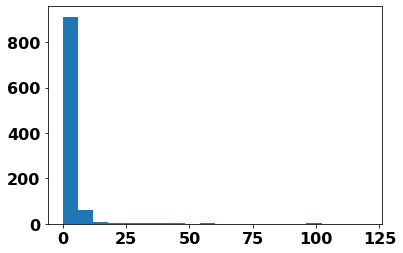

In [108]:
a = np.hstack(price_diff)
plt.hist(a, bins=20)
plt.show()

In [115]:
def price_probability(abs_diff):
    price_diff_list = price_diff[:]
    price_diff_list.sort()
    i = 0
    while price_diff_list[i] < abs_diff:
        if i == len(price_diff_list) - 1:
            return 0
        i += 1
    return 1 - i/len(price_diff_list)

def price_likely_matches(n):
    pass

price_probability(10)

0.049000000000000044

In [18]:
def get_n_matches(n, fn_likely_matches):
    likely_matches = []
    i = 0
    while len(likely_matches) != n:
        m = fn_likely_matches(i)
        if m['zalando_id'] != None:
            likely_matches += [fn_likely_matches(i)]
        i += 1
    return likely_matches

brand_matches = get_n_matches(10, brand_likely_matches)
title_matches = get_n_matches(10, title_likely_matches)
color_matches = get_n_matches(10, color_likely_matches)
#descr_matches = get_n_matches(100, descr_likely_matches)

In [19]:
def is_present(predicted_match):
    zalando_id = predicted_match['zalando_id']
    return len(matches_training_df.loc[matches_training_df['zalando'] == zalando_id]['aboutyou'])

def is_match(predicted_match):
    zalando_id = predicted_match['zalando_id']
    if is_present(predicted_match):
        match = matches_training_df\
        .loc[matches_training_df['zalando'] == zalando_id]['aboutyou'].values[0]
        
        #zalando_brand = zalando_prod_training\
        #                .loc[zalando_prod_training['offer_id'] == zalando_id]['brand'].values[0]
        #zalando_title = zalando_prod_training\
        #                .loc[zalando_prod_training['offer_id'] == zalando_id]['title'].values[0]
        
        #aboutyou_match_truth_id = matches_training_df\
        #                .loc[matches_training_df['zalando'] == zalando_id]['aboutyou'].values[0]
        #aboutyou_brand = aboutyou_prod_training\
        #                .loc[aboutyou_prod_training['offer_id'] == aboutyou_match_truth_id]['brand'].values[0]
        #aboutyou_title = aboutyou_prod_training\
        #                .loc[aboutyou_prod_training['offer_id'] == aboutyou_match_truth_id]['title'].values[0]
        
        #print(#'zalando brand:', zalando_brand, 
              #'aboutyou brand:', aboutyou_brand, 
        #      'zalando title:', zalando_title, 
        #      '- aboutyou_title:', aboutyou_title)
        isin = match in predicted_match['aboutyou_ids']
        #if not isin:
            #print(zalando_brand, aboutyou_brand)
        return isin
    return None

def print_weight(str_feature, matches):
    print(str_feature + ' matching:', 
      calc_match_rate(matches),
      'over:', len(matches), 'matches,',
      'accuracy:', calc_match_accuracy(matches)
     )
    
def calc_match_rate(matches):
    return [is_match(matches[i]) for i in range(len(matches))].count(True) / len(matches)

def calc_match_accuracy(matches, scale=1000):
    return scale / np.mean([len(matches[i]['aboutyou_ids']) for i in range(len(matches))])


print_weight('brand', brand_matches)
print_weight('title', title_matches)
print_weight('color', color_matches)
#print_weight('descr', descr_matches)

brand matching: 0.969 over: 1000 matches, accuracy: 0.16616487643398212
title matching: 0.579 over: 1000 matches, accuracy: 0.7410146417083056
color matching: 0.637 over: 1000 matches, accuracy: 0.11669205107751106


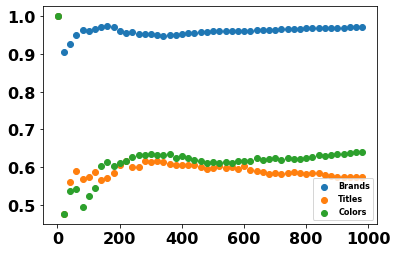

In [26]:
def get_matches_coords(matches):
    x = np.arange(1, len(matches))
    y_list = []
    for i in range(1, len(matches)):
        #y_list += [calc_match_accuracy(matches[0:i]) * calc_match_rate(matches[0:i])]
        y_list += [calc_match_rate(matches[0:i])]
    y = np.array(y_list)
    return x, y

b_x, b_y = get_matches_coords(brand_matches)
t_x, t_y = get_matches_coords(title_matches)
c_x, c_y = get_matches_coords(color_matches)
#d_x, d_y = get_matches_coords(descr_matches)

p_brands = plt.scatter(b_x, b_y)
p_titles = plt.scatter(t_x, t_y)
p_colors = plt.scatter(c_x, c_y)
#p_descrs = plt.scatter(d_x, d_y)

plt.legend((p_brands, p_titles, p_colors),
           ('Brands', 'Titles', 'Colors'),
           scatterpoints=1,
           fontsize=8)

plt.show()

In [32]:
def calculate_match_score(zalando_offer_id, aboutyou_offer_id):
    zalando_offer = zalando_prod_training.loc[zalando_prod_training['offer_id'] == zalando_offer_id]
    aboutyou_offer = aboutyou_prod_training.loc[aboutyou_prod_training['offer_id'] == aboutyou_offer_id]
    zalando_index = zalando_offer.index.values[0]
    
    brand_weight = 0.969
    brand_matches = brand_likely_matches(zalando_index)
    brand_in = aboutyou_offer_id in brand_matches['aboutyou_ids']
    
    title_weight = 0.579
    title_matches = title_likely_matches(zalando_index)
    title_in = aboutyou_offer_id in title_matches['aboutyou_ids']
    
    color_weight = 0.637
    color_matches = color_likely_matches(zalando_index)
    color_in = aboutyou_offer_id in color_matches['aboutyou_ids']
    
    score = int(brand_in) * brand_weight + int(title_in) * title_weight + int(color_in) * color_weight
    print(score)

calculate_match_score('b33f55d6-0149-4063-8b63-3eeae63562a2', 'ad5ceb87-0254-4171-b650-1d4d09f48efc')

0.969
